In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from scipy.constants import pi, c
from scipy.signal import hilbert, find_peaks
from scipy.interpolate import interp1d

In [2]:
plt.rcParams['figure.figsize'] = [10,5]

In [3]:
#Define conversion functions/factors to get to/from meep units and kms
#Length factor to transform lengths in kms
l_unit = 1e-6 #1 um
t_unit = l_unit/c #time unit is length/c

#multiplicative constants to convert frequencies from meep to kms hertz
freq_unit = c/l_unit

print("1 meep Length unit is", l_unit*1e+6, "um")
print("1 meep Time unit is", t_unit*1e+15, "fs")
print("1 meep Frequency unit is", freq_unit*1e-12, "THz")

1 meep Length unit is 1.0 um
1 meep Time unit is 3.3356409519815204 fs
1 meep Frequency unit is 299.792458 THz


# Resolution

In [4]:
#courant factor
S = 0.5

#resolution is number of pixels per meep unit
resolution = 20

#resolutions in meep units
space_res = 1/resolution
time_res = space_res*S

print("Pixel per unit: ", resolution)

print("Space resolution [meep]: ", space_res)
print("Time resolution [meep]: ", time_res)

print("Space resolution [um]: ", space_res*l_unit*1e+6)
print("Time resolution [fs]: ", time_res*t_unit*1e+15)

Pixel per unit:  20
Space resolution [meep]:  0.05
Time resolution [meep]:  0.025
Space resolution [um]:  0.049999999999999996
Time resolution [fs]:  0.08339102379953803


# Geometry Definition
Cell

In [5]:
#define cell size and resolution
#Cell size is in meep units
#center is in (0,0), ranges in x=(-sx/2,sx/2), y=(-sy/2,sy/2)
sx = 24
sy = 15

cell = mp.Vector3(sx, sy)

#boundary conditions thickness
pml_thickness = 1.0

#automatic positioning of boundaries
x_bound_up = sx/2 - pml_thickness
x_bound_low = -sx/2 + pml_thickness

y_bound_up = sy/2 - pml_thickness
y_bound_low = -sy/2 + pml_thickness

# Loop


In [6]:
Dn_values = np.arange(0.1, 2.2, 0.1)
Dn_number = len(Dn_values)

bandgap_mean_array = np.array([])
bandgap_delta_array = np.array([])
bandgap_ratio_array = np.array([])

for index_Dn,Dn in enumerate(Dn_values):

    #materials refractive indexes
    n_1 = 1.45
    n_2 = n_1 + Dn

    print("###############")
    print("## Beginning Iteration ",index_Dn," out of ", Dn_number)
    print("#Delta index:", Dn, "\n")

    print("#Dielectric constant eps_1: ", n_1*n_1)
    print("#Dielectric constant eps_2: ", n_2*n_2)
    print("#Dielectric constant Delta_eps: ", n_1*n_1-n_2*n_2)
    print("#Dielectric constant Ratio: ", (n_1*n_1-n_2*n_2)/(n_1*n_1))


    #Si 3.5
    #SiO2 1.45

    #Bragg params
    #central cavity (if present)
    width_cavity = 1

    #Layer thickness
    width_1 = 0.5
    width_2 = 0.5

    #Half the number of layers
    N_layers = 12

    #The x position of the BR boundaries
    bragg_width = (width_2 + width_1)*N_layers

    #Soure parameters
    source_x = -bragg_width/2 - 4
    source_y = 0

    source_width = 11

    #note: df is not really the frequency sigma
    f_central = 0.25
    df = 0.25


    print("#Source pulse frequency: fcent= ", f_central*freq_unit*1e-12, " THz, df= ",df*freq_unit*1e-12, " THz" )
    print("#Source vacuum wavelength: lambda = ",  c/(f_central*freq_unit)*1e+6, "um, dlambda = ",c/(df*freq_unit)*1e+6,"um")
    print("#Source material 1 wavelength: lambda = ",  (c/n_1)/(f_central*freq_unit)*1e+6, "um, dlambda = ", (c/n_1)/(df*freq_unit)*1e+6,"um")
    print("#Source material 2 wavelength: lambda = ",  (c/n_2)/(f_central*freq_unit)*1e+6, "um, dlambda = ", (c/n_2)/(df*freq_unit)*1e+6,"um")

    #Monitor parameters
    #input
    mon_1_x = -bragg_width/2 - 2
    mon_1_width = sy - 2*pml_thickness

    #output
    mon_2_x = bragg_width/2 + 2
    mon_2_h = sy - 2*pml_thickness

    #number of sampling points in frequency for fourier transform of fields accumulated
    N_freq = 300

    #central frequency
    f_mon_central = f_central
    #width of sampled frequency band
    df_mon = df


    #Point for simulation termination condition
    check_pt = mp.Vector3(0, bragg_width/2 + 0.5)

    #Background material
    geometry = [mp.Block(mp.Vector3(mp.inf, mp.inf, mp.inf),
                        center=mp.Vector3(0,0),
                        material=mp.Medium(index=n_1))]

    #define sources
    #gaussian pulse with f_central and df
    sources = [mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*2),
                        component=mp.Ez,
                        center=mp.Vector3(source_x, source_y),
                        size=mp.Vector3(0, source_width))]

    #define boundary conditions
    pml_layers = [mp.PML(pml_thickness)]

    #Instance simulation with chosen parameters
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        sources=sources,
                        geometry=geometry,
                        resolution=resolution)

    # Flux Monitor 1
    incident_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, 0), size=mp.Vector3(0, mon_1_width, 0))
    incident = sim.add_flux(f_mon_central, df_mon, N_freq, incident_fr)

    # Flux Monitor 2
    tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, 0), size=mp.Vector3(0,mon_2_h,0))
    tran = sim.add_flux(f_mon_central, df_mon, N_freq, tran_fr)

    #Simulate
    mp.verbosity(0)
    sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, check_pt, 5e-3))

    #Get Fourier-transformed fields of incident pulse
    norm_incident_data = sim.get_flux_data(incident)

    #Get fluxes from fourier transformed fields transmitted
    norm_tran_flux = mp.get_fluxes(tran)

    #Get fluxes from fourier transformed incident fields
    norm_inc_flux = mp.get_fluxes(incident)

    flux_freqs = mp.get_flux_freqs(tran)

    sim.reset_meep()

    #define geometry

    #Background material
    geometry = [mp.Block(mp.Vector3(mp.inf, mp.inf, mp.inf),
                        center=mp.Vector3(0,0),
                        material=mp.Medium(index=n_1))]

    #Layers Material
    for ii in range(N_layers):
        geometry.append(mp.Block(mp.Vector3(width_2, mp.inf, mp.inf),
                        center=mp.Vector3(ii*(width_1+width_2) -bragg_width/2 + width_1 + width_2/2, 0),
                        material=mp.Medium(index=n_2)))
        
    #define sources
    sources = [mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*2),
                        component=mp.Ez,
                        center=mp.Vector3(source_x, 0),
                        size=mp.Vector3(0, source_width))]

    #define boundary conditions
    pml_layers = [mp.PML(pml_thickness)]


    #Instance simulation with chosen parameters
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        resolution=resolution)

    #Desired frequencies are in (fcen-df/2, fcen+df/2)

    # Flux Monitor 1
    refl_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, 0), size=mp.Vector3(0,mon_1_width,0))
    refl = sim.add_flux(f_mon_central, df_mon, N_freq, refl_fr)

    # Flux Monitor 2
    tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, 0), size=mp.Vector3(0,mon_2_h,0))
    tran = sim.add_flux(f_mon_central, df_mon, N_freq, tran_fr)
    
    #load normalization data
    sim.load_minus_flux_data(refl, norm_incident_data)

    mp.verbosity(0)
    sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, check_pt, 5e-3))
    #until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,1e-3))

    # Get Final Fluxes
    bragg_tran_flux = np.array(mp.get_fluxes(tran))
    bragg_refl_flux = np.array(mp.get_fluxes(refl))*(-1)

    flux_freqs = np.array(mp.get_flux_freqs(refl))    

    # Transmittance and reflectance

    wvlength = 1/flux_freqs

    T = bragg_tran_flux/norm_tran_flux
    R = bragg_refl_flux/norm_tran_flux
    Losses = 1-T-R    

    diff_T = np.diff(T)
    diff_R = np.diff(R)
    diff_Losses = np.diff(Losses)

    diff_R_abs =np.abs(diff_R)
    max_index = np.argmax(diff_R)

    peaks, _ = find_peaks(diff_R_abs, height=0.01)
    ind = np.argpartition(diff_R[peaks][peaks>=max_index], -2)[-2:]
    bandgap_bounds = flux_freqs[peaks][peaks>=max_index][ind][::-1]

    bandgap_mean = np.mean(bandgap_bounds)
    bandgap_delta = bandgap_bounds[1]-bandgap_bounds[0]
    bandgap_ratio = bandgap_delta/bandgap_mean

    print("Mean freqeuency: ",bandgap_mean)
    print("Delta freqeuency: ",bandgap_delta)
    print("Ratio Delta/mean: ",bandgap_ratio)

    bandgap_mean_array = np.append(bandgap_mean_array, bandgap_mean)
    bandgap_delta_array = np.append(bandgap_delta_array, bandgap_delta)
    bandgap_ratio_array = np.append(bandgap_ratio_array, bandgap_ratio)



###############
## Beginning Iteration  0  out of  21
#Delta index: 0.1 

#Dielectric constant eps_1:  2.1025
#Dielectric constant eps_2:  2.4025000000000003
#Dielectric constant Delta_eps:  -0.30000000000000027
#Dielectric constant Ratio:  -0.14268727705112974
#Source pulse frequency: fcent=  74.9481145  THz, df=  74.9481145  THz
#Source vacuum wavelength: lambda =  4.0 um, dlambda =  4.0 um
#Source material 1 wavelength: lambda =  2.7586206896551726 um, dlambda =  2.7586206896551726 um
#Source material 2 wavelength: lambda =  2.5806451612903225 um, dlambda =  2.5806451612903225 um
Mean freqeuency:  0.33319397993311034
Delta freqeuency:  0.0317725752508361
Ratio Delta/mean:  0.09535759096612291
###############
## Beginning Iteration  1  out of  21
#Delta index: 0.2 

#Dielectric constant eps_1:  2.1025
#Dielectric constant eps_2:  2.7224999999999997
#Dielectric constant Delta_eps:  -0.6199999999999997
#Dielectric constant Ratio:  -0.294887039239001
#Source pulse frequency: fcent=  74.

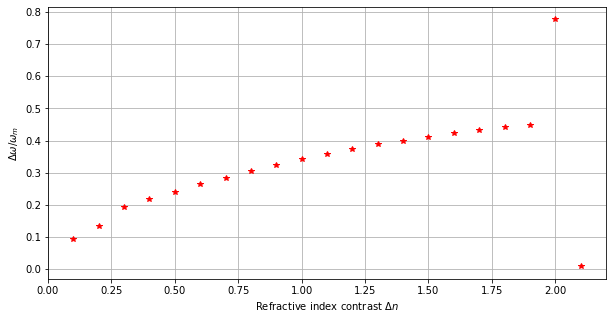

In [ ]:
fig = plt.figure()

plt.plot(Dn_values, bandgap_ratio_array, "r*")

plt.xlabel(r"Refractive index contrast $\Delta n$")
plt.ylabel(r"$\Delta \omega / \omega_m$")
plt.grid()



In [ ]:
fig = plt.figure()

plt.plot(Dn_values, bandgap_mean_array, "r*")

plt.xlabel(r"Refractive index contrast $\Delta n$")
plt.ylabel(r"$\omega_m$")
plt.grid()



In [ ]:
fig = plt.figure()

plt.plot(Dn_values, bandgap_delta_array, "r*")

plt.xlabel(r"Refractive index contrast $\Delta n$")
plt.ylabel(r"$\Delta \omega")
plt.grid()


Dubbi: formalmente come faccio a costruire una sorgente che eccita solo alcuni modi della struttura?
Come faccio a capire quali modi eccita una sorgente arbitraria?
Come misuro aitomaticamente il bandgap?

# Notes
- Dn = +1.4, n_1 = 1.45, wm = 0.225, wmin = 0.18, wmax =0.275 Dw=0.095
- Dn = 1, n_1 = 1.45, wm = 0.255, wmin = 0.215, wmax =0.287 Dw=0.072